In [15]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

% matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

In [13]:
gestures = {'L_': 'L',
           'fi': 'Fist',
           'C_': 'C',
           'ok': 'Okay',
           'pe': 'Peace',
           'pa': 'Palm'
            }

gestures_map = {'Fist' : 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Peace': 4
                }

In [3]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = [] 
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))   

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

#### Get 'silhouette' data (this is the data we used for the final model)

In [4]:
relative_path = './frames/silhouettes/'
rgb = False

# # This method processes the data
X_data, y_data = walk_file_tree(relative_path)

# Can also optionally use a class to get this data, in order to keep it separate from Drawing data
silhouette = Data()
silhouette.X_data, silhouette.y_data = walk_file_tree(relative_path)

In [5]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (2748, 224, 224, 3)
y_data shape: (2748, 5)


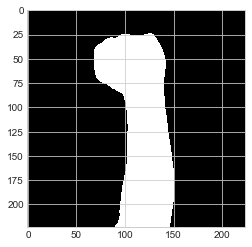

In [6]:
plt.imshow(X_data[0])

#### Bring in Kaggle data (having more data will increase accuracy of the model)  

In [ ]:
gestures_map = {3: 0,
                2: 1,
                7: 2,
                1: 3,
                'Peace': 4
                }
X_data = []
y_data = []

root_dir = os.fsencode('./data/gestures_data/')

for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        if not file.startswith(b'.'):
            gesture_name = int(file.decode('utf8')[10:11])
            if gesture_name in [1, 2, 3, 7]:
                path = os.path.join(directory, file).decode('utf8')
                y_data.append(gestures_map[gesture_name])

                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.flip(img, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
                ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                thresh = cv2.resize(thresh, (224, 224))
                thresh = np.array(thresh)
                X_data.append(thresh)

            else:
                continue

process_data(X_data, y_data)


In [ ]:
# Have to add a column of zeroes for the 'Peace' sign, since the Kaggle data does not have photos of 
# 'Peace' signs.
z = np.zeros((len(y_data),1))
y_data = np.append(y_data, z, axis=1)

In [16]:
y_data.shape

(2748, 5)

#### Notice that the Kaggle images are now thresholded and binarized

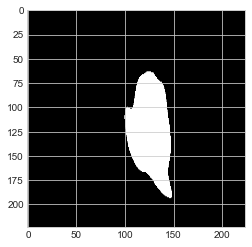

In [76]:
plt.imshow(.5 - X_data[250])

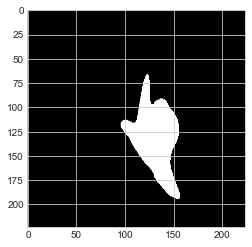

In [81]:
plt.imshow(.5 - X_data[100])

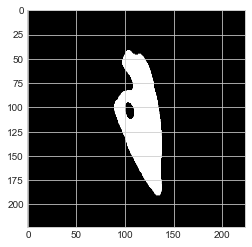

In [83]:
plt.imshow(.5 - X_data[1200])

#### Train-test split

In [17]:
# X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(image_rgb, y_data, test_size = 0.2, random_state=12, stratify=y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

#### Build the VGG Model

In [40]:
file_path = 'models\VGG_cross_validated.h5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)


In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

base_model = vgg_base  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_train, y_train), verbose=1,
          callbacks=[early_stopping, model_checkpoint])


In [ ]:
# load VGG16
# Get back the convolutional part of a VGG network trained on ImageNet

imageSize = 224
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

base_model = model1  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_train, y_train), verbose=1,
          callbacks=[early_stopping, model_checkpoint])


#### Save and import model

In [88]:
# model.save('models/VGG_reversed.h5')

from keras.models import load_model
model = load_model('Users\lenovo\Desktop\Gesture\models\VGG_cross_validated.h5')

#### Get classification metrics

In [48]:
def get_classification_metrics(X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))

**VGG_cross_validated model**

Note that there are no predictions for class \#5 since 'Peace' sign did not exist in cross_val images

In [49]:
# get_classification_metrics(X_data, y_data)

[[200   0   0   0   0]
 [  0 199   0   1   0]
 [  0   0 200   0   0]
 [ 11   0   0 187   2]
 [  0   0   0   0   0]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       200
           1       1.00      0.99      1.00       200
           2       1.00      1.00      1.00       200
           3       0.99      0.94      0.96       200
           4       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.99      0.98      0.98       800

